In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import numpy as np
from scipy.stats import norm, multivariate_normal as mvn
from sklearn.model_selection import KFold 

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Customize font sizes for better visualization
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

In [2]:
def generate_data(sample, gmmparam):
    n = gmmparam['meanvectors'].shape[1]
    X = np.zeros([sample, n])
    labels = np.zeros(sample)
    u = np.random.rand(sample)
    threshold = np.cumsum(gmmparam['priors'])
    threshold = np.insert(threshold, 0, 0)
    L = np.array(range(len(gmmparam['priors'])))
    for l in L:
        indices = np.argwhere((threshold[l] <= u) & (u <= threshold[l+1]))[:, 0]
        N_labels = len(indices)
        labels[indices] = l * np.ones(N_labels)
        X[indices, :] = mvn.rvs(gmmparam['meanvectors'][l], gmmparam['covariancematrices'][l], N_labels)
    return X, labels

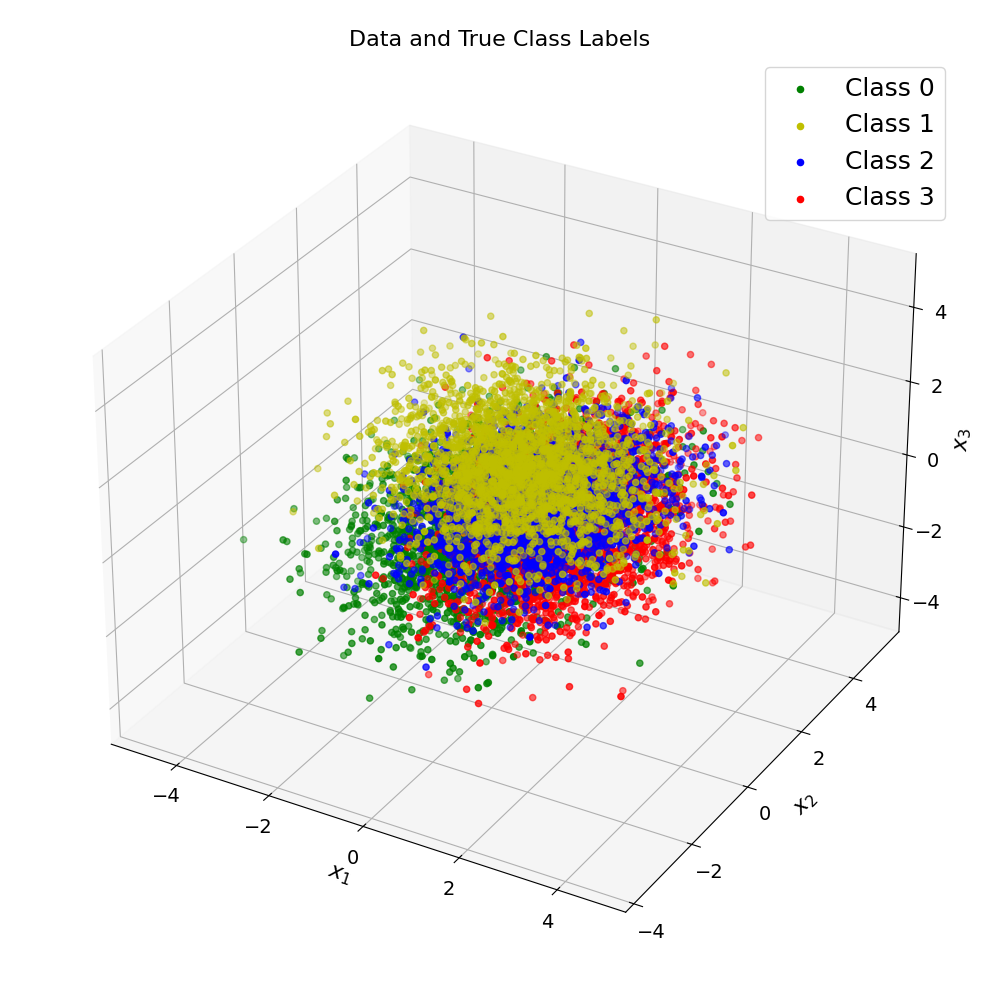

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget 



samples = 10000
classes = 4

gmmparam = {
    'priors': np.ones(classes) / classes,
    'meanvectors': np.array([[0, 0, 0],
               [0, 1, 1],
               [1, 0, 1],
               [1, 1, 0]]),
    'covariancematrices': np.array([[[1.5, 0.3, 0.3],
                   [0.3, 1, 0.5],
                   [0.3, 0.5, 1]],
                  
                  [[1.5, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]],
                  
                  [[1, 0.2, 0.2],
                   [0.2, 1, 0],
                   [0.2, 0, 1]],
                  
                  [[1, 0, 0.2],
                   [0, 1.5, 0],
                   [0.2, 0, 1.5]]])
}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X,labels=generate_data(samples, gmmparam)
ax.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels== 0, 2], c='g', label="Class 0")
ax.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='y', label="Class 1")
ax.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='b', label="Class 2")
ax.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='r', label="Class 3")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
class TwolayerMLP(nn.Module):
    def __init__(self, n, P, C):
        super(TwolayerMLP, self).__init__()
        self.input_fc = nn.Linear(n, P)
        self.output_fc = nn.Linear(P, C)
    
    def forward(self, X):
        X = self.input_fc(X)
        X = F.relu(X)
        y = self.output_fc(X)
        return y

In [5]:
train_sample = [100, 500, 1000, 5000,10000]

test_sample = 100000 

# Lists to hold the corresponding input matrices, target vectors and sample label counts
X_train = []
Y_train = []

for N_i in train_sample:
    print("Generating the Training data set for sample = {}".format(N_i))

    X_i, Y_i = generate_data(N_i, gmmparam)

    X_train.append(X_i)
    Y_train.append(Y_i)

print("Generating the Test set = {}".format(test_sample))
X_test, Y_test = generate_data(test_sample, gmmparam)


Generating the Training data set for sample = 100
Generating the Training data set for sample = 500
Generating the Training data set for sample = 1000
Generating the Training data set for sample = 5000
Generating the Training data set for sample = 10000
Generating the Test set = 100000


In [6]:
class_condition_likelihoods = np.array([mvn.pdf(X_test, gmmparam['meanvectors'][i], gmmparam['covariancematrices'][i]) for i in range(classes)])
decisions = np.argmax(class_condition_likelihoods, axis=0)
wrong_samples = sum(decisions != Y_test)
minimum_probability_error = (wrong_samples / test_sample)
print("Probability of Error on Test Set using the true Data pdf = {}".format(minimum_probability_error))

Probability of Error on Test Set using the true Data pdf = 0.44829


In [7]:
def train_model(model, data, labels, optimizer, criterion=nn.CrossEntropyLoss(), num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, loss

def predict_model(model, data):
    model.eval()
    with torch.no_grad():
        predicted_labels = model(data)
        predicted_labels = predicted_labels.detach().numpy()
        return np.argmax(predicted_labels, 1)

In [8]:
def k_fold_cv_perceptrons(K, P_list, data, labels):
    """
    Performs k-fold cross-validation to select the optimal number of perceptrons for a two-layer MLP
    model based on the minimum validation error.

    Args:
    K (int): The number of folds for k-fold cross-validation.
    P_list (list): A list of integers representing the number of perceptrons to test.
    data (numpy.ndarray): The dataset features.
    labels (numpy.ndarray): The dataset labels.

    Returns:
    optimal_P (int): The optimal number of perceptrons.
    error_valid_m (numpy.ndarray): The mean validation error across K folds for each value of P.
    """
    kf = KFold(n_splits=K, shuffle=True)

    error_valid_mk = np.zeros((len(P_list), K))

    for p_idx, p in enumerate(P_list):
        for fold_idx, (train_indices, valid_indices) in enumerate(kf.split(data)):
            X_train, y_train = torch.FloatTensor(data[train_indices]), torch.LongTensor(labels[train_indices])
            X_valid, y_valid = torch.FloatTensor(data[valid_indices]), labels[valid_indices]

            model = TwolayerMLP(X_train.shape[1], p, classes)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            model, _ = train_model(model, X_train, y_train, optimizer)

            predictions = predict_model(model, X_valid)
            error_valid_mk[p_idx, fold_idx] = np.sum(predictions != y_valid) / len(y_valid)

    error_valid_m = np.mean(error_valid_mk, axis=1)
    optimal_P = P_list[np.argmin(error_valid_m)]

    return optimal_P, error_valid_m

	# of Training Samples 	Best # of Perceptrons 	Pr(error)
		 100 			 24 		  0.490
		 500 			 128 		  0.436
		 1000 			 256 		  0.443
		 5000 			 512 		  0.458
		 10000 			 256 		  0.452


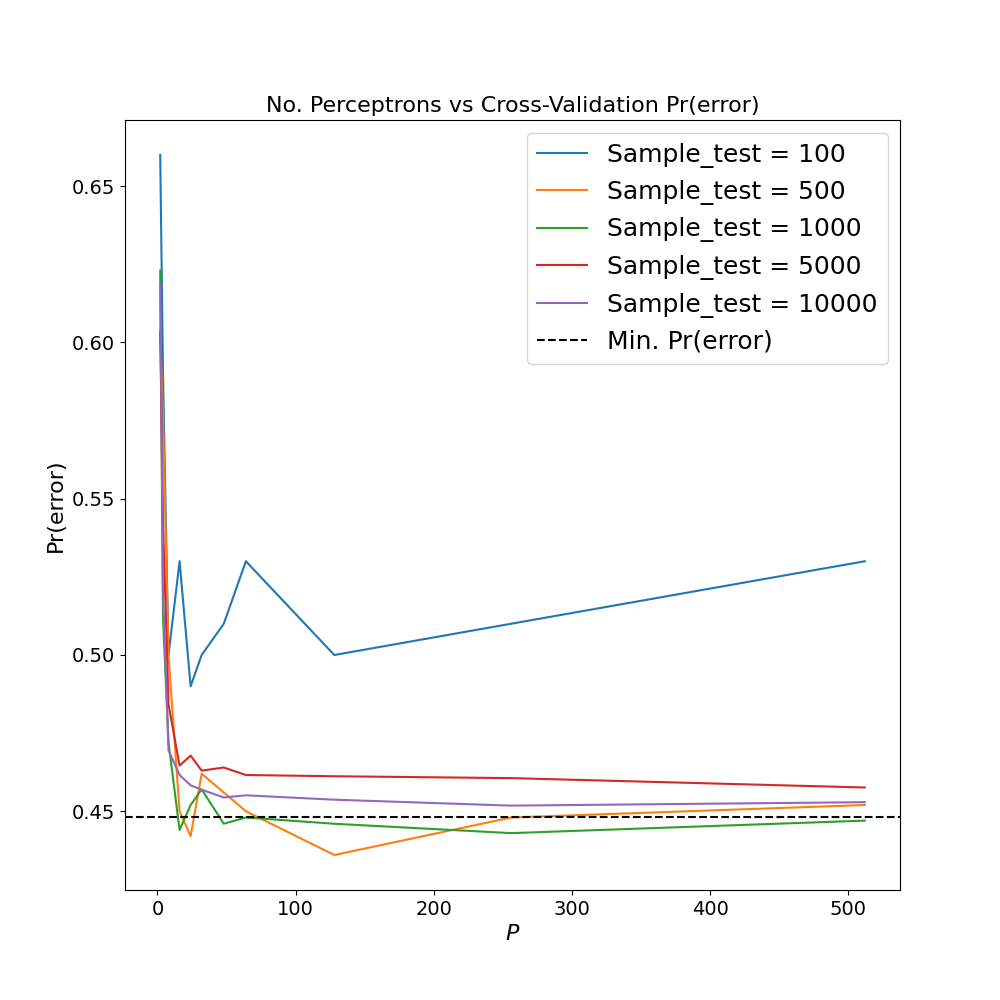

In [9]:
K = 10
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128, 256, 512]
best_P_list = []

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
print("\t# of Training Samples \tBest # of Perceptrons \tPr(error)")
for i in range(len(X_train)):
    P_best, P_CV_err = k_fold_cv_perceptrons(K, P_list, X_train[i], Y_train[i])
    best_P_list.append(P_best)
    print("\t\t %d \t\t\t %d \t\t  %.3f" % (train_sample[i], P_best, np.min(P_CV_err)))
    ax.plot(P_list, P_CV_err, label="Sample_test = {}".format(train_sample[i]))

plt.axhline(y=minimum_probability_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.set_title("No. Perceptrons vs Cross-Validation Pr(error)")
ax.set_xlabel(r"$P$")
ax.set_ylabel("Pr(error)")
ax.legend()
plt.show()

In [10]:
trained_models = []
num_restarts = 10
for i in range(len(X_train)):
    print("Training model for N = {}".format(X_train[i].shape[0]))
    X_i = torch.FloatTensor(X_train[i])
    y_i = torch.LongTensor(Y_train[i])
    best_models = []
    best_losses = []
    # Remove chances of falling into suboptimal local minima
    for r in range(num_restarts):
        model = TwolayerMLP(X_i.shape[1], best_P_list[i], classes)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        # Trained model
        model, loss = train_model(model, X_i, y_i, optimizer)
        best_models.append(model)
        best_losses.append(loss.detach().item())

    # Add best model from multiple restarts to list
    trained_models.append(best_models[np.argmin(best_losses)])

Training model for N = 100
Training model for N = 500
Training model for N = 1000
Training model for N = 5000
Training model for N = 10000


Probability of error results summarized below per trained MLP: 

	 # of Training Samples 	 Pr(error)
		 100 		   0.477
		 500 		   0.457
		 1000 		   0.453
		 5000 		   0.450
		 10000 		   0.451


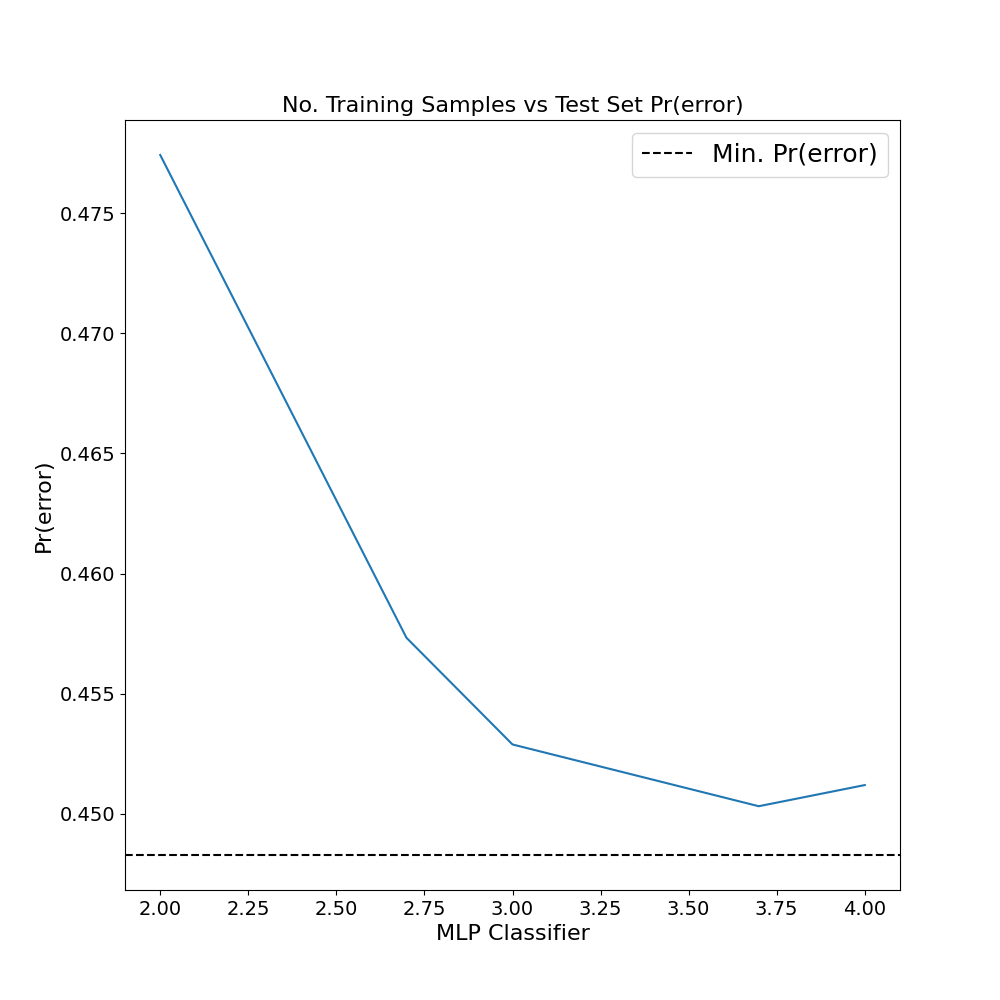

In [11]:
# First conver test set data to tensor suitable for PyTorch models
X_test_tensor = torch.FloatTensor(X_test)
pr_error_list = []

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Estimate loss (probability of error) for each trained MLP model by testing on the test data set
print("Probability of error results summarized below per trained MLP: \n")
print("\t # of Training Samples \t Pr(error)")
for i in range(len(X_train)):
    # Evaluate the neural network on the test set
    predictions = predict_model(trained_models[i], X_test_tensor)
    # Compute the probability of error estimates
    prob_error = np.sum(predictions != Y_test) / len(Y_test)
    print("\t\t %d \t\t   %.3f" % (train_sample[i], prob_error))
    pr_error_list.append(prob_error)

plt.axhline(y=minimum_probability_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.plot(np.log10(train_sample), pr_error_list)
ax.set_title("No. Training Samples vs Test Set Pr(error)")
ax.set_xlabel("MLP Classifier")
ax.set_ylabel("Pr(error)")


ax.legend()
plt.show()

In [26]:
def generate_data(n_samples):
    data_1 = []
    max_order = max(model_orders)
    for k in range(len(true_gmm_param['weights'])):
        samples = np.random.multivariate_normal(
            true_gmm_param['means'][k],
            true_gmm_param['covariancematrices'][k],
            max(n_samples, max_order)  # Ensure at least max_order samples for each component
        )
        data_1.append(samples)
    data = np.vstack(data_1)
    return data


In [27]:
true_gmm_param = {
    'means': np.array([[0, 0], [2, 2], [0, 4], [4, 0]]),
    'covariancematrices':np.array([[[1, 0], [0, 1]], 
                 [[1, 0.5], [0.5, 1]], 
                 [[1, -0.7], [-0.5, 1]], 
                 [[1, 0], [0, 1]]]),
    'weights': np.array([0.2, 0.3, 0.1, 0.4])
}

n_experiments = 100
n_splits = 10
n_samples = [10, 100, 1000]
model_orders = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

freq = np.zeros((len(n_samples), len(model_orders)))

In [28]:
def kfold_validation(freq):
    for exp in range(n_experiments):
        for i, n in enumerate(n_samples):
            # Ensure that n is greater than or equal to the maximum model order
            max_order = max(model_orders)
            if n < max_order:
                raise ValueError(f"Number of samples ({n}) should be greater than or equal to the maximum model order ({max_order}).")
            
            X = generate_data(n)
            cv_scores = np.zeros((n_splits, len(model_orders)))
            kf = KFold(n_splits=n_splits)
            for j, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X[train_index], X[test_index]
                for k, order in enumerate(model_orders):
                    gmm = GaussianMixture(n_components=order, covariance_type='full')
                    gmm.fit(X_train)
                    cv_scores[j, k] = gmm.score(X_test)
            freq[i] = np.bincount(np.argmax(cv_scores, axis=1), minlength=len(model_orders))
        
        avg_freq = freq / ((exp + 1) * n_splits)
        print(f"Frequencies for experiment = {exp + 1}")
        for i, n in enumerate(n_samples):
            print(f"n_samples={n}")
            for j, order in enumerate(model_orders):
                print(f"  order = {order} : Frequency = {avg_freq[i, j]:.4f}")
    
    freq /= (n_experiments * n_splits)
    return freq


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 1
n_samples=10
  order = 1 : Frequency = 0.2000
  order = 2 : Frequency = 0.4000
  order = 3 : Frequency = 0.1000
  order = 4 : Frequency = 0.1000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.1000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.1000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.3000
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.4000
  order = 4 : Frequency = 0.1000
  order = 5 : Frequency = 0.1000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.1000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.2000
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.2000
  order = 4 : Frequency = 0.3000
  order = 5 : Frequency = 0.1000
  order = 6 : Frequency = 0.1000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 2
n_samples=10
  order = 1 : Frequency = 0.1000
  order = 2 : Frequency = 0.1500
  order = 3 : Frequency = 0.0500
  order = 4 : Frequency = 0.1000
  order = 5 : Frequency = 0.0500
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0500
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.1000
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0500
  order = 4 : Frequency = 0.1500
  order = 5 : Frequency = 0.0500
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.1000
  order = 10 : Frequency = 0.0500
n_samples=1000
  order = 1 : Frequency = 0.1000
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0500
  order = 4 : Frequency = 0.1500
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0500
  order = 7 : Frequency = 0.0500
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 3
n_samples=10
  order = 1 : Frequency = 0.1333
  order = 2 : Frequency = 0.0333
  order = 3 : Frequency = 0.1000
  order = 4 : Frequency = 0.0667
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0667
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0667
  order = 4 : Frequency = 0.0667
  order = 5 : Frequency = 0.0333
  order = 6 : Frequency = 0.0333
  order = 7 : Frequency = 0.0333
  order = 8 : Frequency = 0.0333
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0667
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.1000
  order = 4 : Frequency = 0.1667
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 4
n_samples=10
  order = 1 : Frequency = 0.0750
  order = 2 : Frequency = 0.0500
  order = 3 : Frequency = 0.1000
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0250
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0500
  order = 2 : Frequency = 0.0500
  order = 3 : Frequency = 0.0500
  order = 4 : Frequency = 0.0250
  order = 5 : Frequency = 0.0500
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0250
n_samples=1000
  order = 1 : Frequency = 0.0500
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0500
  order = 4 : Frequency = 0.0750
  order = 5 : Frequency = 0.0500
  order = 6 : Frequency = 0.0250
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 5
n_samples=10
  order = 1 : Frequency = 0.0200
  order = 2 : Frequency = 0.0400
  order = 3 : Frequency = 0.0600
  order = 4 : Frequency = 0.0400
  order = 5 : Frequency = 0.0200
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0200
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0600
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0600
  order = 4 : Frequency = 0.0400
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0200
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0200
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0400
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0600
  order = 4 : Frequency = 0.0200
  order = 5 : Frequency = 0.0400
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0200
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 6
n_samples=10
  order = 1 : Frequency = 0.0667
  order = 2 : Frequency = 0.0500
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0333
  order = 5 : Frequency = 0.0167
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0333
  order = 2 : Frequency = 0.0167
  order = 3 : Frequency = 0.0333
  order = 4 : Frequency = 0.0167
  order = 5 : Frequency = 0.0333
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0167
  order = 9 : Frequency = 0.0167
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0333
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0500
  order = 5 : Frequency = 0.0333
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 7
n_samples=10
  order = 1 : Frequency = 0.0429
  order = 2 : Frequency = 0.0286
  order = 3 : Frequency = 0.0143
  order = 4 : Frequency = 0.0143
  order = 5 : Frequency = 0.0143
  order = 6 : Frequency = 0.0143
  order = 7 : Frequency = 0.0143
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0286
  order = 2 : Frequency = 0.0143
  order = 3 : Frequency = 0.0286
  order = 4 : Frequency = 0.0429
  order = 5 : Frequency = 0.0143
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0143
n_samples=1000
  order = 1 : Frequency = 0.0286
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0143
  order = 4 : Frequency = 0.0429
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0286
  order = 7 : Frequency = 0.0143
  order = 8 : Frequency = 0.0143
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 8
n_samples=10
  order = 1 : Frequency = 0.0125
  order = 2 : Frequency = 0.0375
  order = 3 : Frequency = 0.0125
  order = 4 : Frequency = 0.0500
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0125
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0250
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0250
  order = 4 : Frequency = 0.0250
  order = 5 : Frequency = 0.0125
  order = 6 : Frequency = 0.0375
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0250
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0125
  order = 4 : Frequency = 0.0500
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0125
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 9
n_samples=10
  order = 1 : Frequency = 0.0222
  order = 2 : Frequency = 0.0111
  order = 3 : Frequency = 0.0333
  order = 4 : Frequency = 0.0111
  order = 5 : Frequency = 0.0111
  order = 6 : Frequency = 0.0222
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0222
  order = 2 : Frequency = 0.0111
  order = 3 : Frequency = 0.0222
  order = 4 : Frequency = 0.0111
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0222
  order = 8 : Frequency = 0.0222
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0222
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0111
  order = 4 : Frequency = 0.0333
  order = 5 : Frequency = 0.0111
  order = 6 : Frequency = 0.0111
  order = 7 : Frequency = 0.0111
  order = 8 : Frequency = 0.0000
 

/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 10
n_samples=10
  order = 1 : Frequency = 0.0300
  order = 2 : Frequency = 0.0200
  order = 3 : Frequency = 0.0300
  order = 4 : Frequency = 0.0100
  order = 5 : Frequency = 0.0100
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0200
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0200
  order = 4 : Frequency = 0.0100
  order = 5 : Frequency = 0.0200
  order = 6 : Frequency = 0.0100
  order = 7 : Frequency = 0.0100
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0100
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0200
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0200
  order = 5 : Frequency = 0.0200
  order = 6 : Frequency = 0.0200
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0100


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 11
n_samples=10
  order = 1 : Frequency = 0.0273
  order = 2 : Frequency = 0.0364
  order = 3 : Frequency = 0.0091
  order = 4 : Frequency = 0.0182
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0273
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0182
  order = 4 : Frequency = 0.0182
  order = 5 : Frequency = 0.0091
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0091
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0091
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0182
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0182
  order = 4 : Frequency = 0.0364
  order = 5 : Frequency = 0.0091
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 12
n_samples=10
  order = 1 : Frequency = 0.0083
  order = 2 : Frequency = 0.0167
  order = 3 : Frequency = 0.0250
  order = 4 : Frequency = 0.0333
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0167
  order = 2 : Frequency = 0.0083
  order = 3 : Frequency = 0.0083
  order = 4 : Frequency = 0.0250
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0083
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0083
  order = 10 : Frequency = 0.0083
n_samples=1000
  order = 1 : Frequency = 0.0167
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0250
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0167
  order = 7 : Frequency = 0.0083
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 13
n_samples=10
  order = 1 : Frequency = 0.0462
  order = 2 : Frequency = 0.0077
  order = 3 : Frequency = 0.0154
  order = 4 : Frequency = 0.0077
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0154
  order = 2 : Frequency = 0.0077
  order = 3 : Frequency = 0.0154
  order = 4 : Frequency = 0.0231
  order = 5 : Frequency = 0.0077
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0077
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0154
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0154
  order = 4 : Frequency = 0.0154
  order = 5 : Frequency = 0.0077
  order = 6 : Frequency = 0.0077
  order = 7 : Frequency = 0.0077
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 14
n_samples=10
  order = 1 : Frequency = 0.0143
  order = 2 : Frequency = 0.0286
  order = 3 : Frequency = 0.0143
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0143
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0143
  order = 2 : Frequency = 0.0071
  order = 3 : Frequency = 0.0214
  order = 4 : Frequency = 0.0143
  order = 5 : Frequency = 0.0143
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0143
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0071
  order = 4 : Frequency = 0.0286
  order = 5 : Frequency = 0.0143
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0071


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 15
n_samples=10
  order = 1 : Frequency = 0.0267
  order = 2 : Frequency = 0.0267
  order = 3 : Frequency = 0.0067
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0067
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0133
  order = 2 : Frequency = 0.0067
  order = 3 : Frequency = 0.0267
  order = 4 : Frequency = 0.0067
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0067
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0067
n_samples=1000
  order = 1 : Frequency = 0.0133
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0067
  order = 4 : Frequency = 0.0267
  order = 5 : Frequency = 0.0067
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0067
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 16
n_samples=10
  order = 1 : Frequency = 0.0063
  order = 2 : Frequency = 0.0187
  order = 3 : Frequency = 0.0125
  order = 4 : Frequency = 0.0063
  order = 5 : Frequency = 0.0063
  order = 6 : Frequency = 0.0125
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0125
  order = 2 : Frequency = 0.0063
  order = 3 : Frequency = 0.0250
  order = 4 : Frequency = 0.0125
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0063
n_samples=1000
  order = 1 : Frequency = 0.0125
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0063
  order = 4 : Frequency = 0.0250
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 17
n_samples=10
  order = 1 : Frequency = 0.0176
  order = 2 : Frequency = 0.0176
  order = 3 : Frequency = 0.0059
  order = 4 : Frequency = 0.0118
  order = 5 : Frequency = 0.0059
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0118
  order = 2 : Frequency = 0.0059
  order = 3 : Frequency = 0.0059
  order = 4 : Frequency = 0.0118
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0059
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0118
  order = 9 : Frequency = 0.0059
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0118
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0235
  order = 4 : Frequency = 0.0235
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 18
n_samples=10
  order = 1 : Frequency = 0.0278
  order = 2 : Frequency = 0.0111
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0056
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0056
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0056
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0111
  order = 2 : Frequency = 0.0056
  order = 3 : Frequency = 0.0111
  order = 4 : Frequency = 0.0111
  order = 5 : Frequency = 0.0111
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0056
n_samples=1000
  order = 1 : Frequency = 0.0111
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0111
  order = 4 : Frequency = 0.0222
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 19
n_samples=10
  order = 1 : Frequency = 0.0053
  order = 2 : Frequency = 0.0158
  order = 3 : Frequency = 0.0053
  order = 4 : Frequency = 0.0105
  order = 5 : Frequency = 0.0105
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0053
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0105
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0158
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0053
  order = 6 : Frequency = 0.0105
  order = 7 : Frequency = 0.0053
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0053
n_samples=1000
  order = 1 : Frequency = 0.0105
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0053
  order = 4 : Frequency = 0.0105
  order = 5 : Frequency = 0.0053
  order = 6 : Frequency = 0.0053
  order = 7 : Frequency = 0.0053
  order = 8 : Frequency = 0.0105


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 20
n_samples=10
  order = 1 : Frequency = 0.0150
  order = 2 : Frequency = 0.0050
  order = 3 : Frequency = 0.0250
  order = 4 : Frequency = 0.0050
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0150
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0200
  order = 4 : Frequency = 0.0050
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0050
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0050
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0100
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0100
  order = 5 : Frequency = 0.0100
  order = 6 : Frequency = 0.0050
  order = 7 : Frequency = 0.0050
  order = 8 : Frequency = 0.0050


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 21
n_samples=10
  order = 1 : Frequency = 0.0095
  order = 2 : Frequency = 0.0095
  order = 3 : Frequency = 0.0095
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0095
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0095
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0190
  order = 2 : Frequency = 0.0048
  order = 3 : Frequency = 0.0143
  order = 4 : Frequency = 0.0048
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0048
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0095
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0048
  order = 4 : Frequency = 0.0190
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0048
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0048


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 22
n_samples=10
  order = 1 : Frequency = 0.0091
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0182
  order = 4 : Frequency = 0.0045
  order = 5 : Frequency = 0.0045
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0045
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0045
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0091
  order = 2 : Frequency = 0.0045
  order = 3 : Frequency = 0.0091
  order = 4 : Frequency = 0.0045
  order = 5 : Frequency = 0.0091
  order = 6 : Frequency = 0.0045
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0045
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0091
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0136
  order = 4 : Frequency = 0.0091
  order = 5 : Frequency = 0.0091
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0045


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 23
n_samples=10
  order = 1 : Frequency = 0.0174
  order = 2 : Frequency = 0.0130
  order = 3 : Frequency = 0.0087
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0043
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0087
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0043
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0087
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0043
  order = 8 : Frequency = 0.0043
  order = 9 : Frequency = 0.0043
  order = 10 : Frequency = 0.0043
n_samples=1000
  order = 1 : Frequency = 0.0087
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0174
  order = 4 : Frequency = 0.0130
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0043


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 24
n_samples=10
  order = 1 : Frequency = 0.0167
  order = 2 : Frequency = 0.0042
  order = 3 : Frequency = 0.0083
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0042
  order = 7 : Frequency = 0.0042
  order = 8 : Frequency = 0.0042
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0083
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0125
  order = 4 : Frequency = 0.0042
  order = 5 : Frequency = 0.0083
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0042
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0042
n_samples=1000
  order = 1 : Frequency = 0.0083
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0125
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0125
  order = 7 : Frequency = 0.0042
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 25
n_samples=10
  order = 1 : Frequency = 0.0120
  order = 2 : Frequency = 0.0080
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0040
  order = 5 : Frequency = 0.0080
  order = 6 : Frequency = 0.0080
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0080
  order = 2 : Frequency = 0.0040
  order = 3 : Frequency = 0.0040
  order = 4 : Frequency = 0.0080
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0080
  order = 8 : Frequency = 0.0040
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0040
n_samples=1000
  order = 1 : Frequency = 0.0080
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0160
  order = 4 : Frequency = 0.0120
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0040
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 26
n_samples=10
  order = 1 : Frequency = 0.0115
  order = 2 : Frequency = 0.0115
  order = 3 : Frequency = 0.0038
  order = 4 : Frequency = 0.0038
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0077
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0077
  order = 2 : Frequency = 0.0038
  order = 3 : Frequency = 0.0038
  order = 4 : Frequency = 0.0077
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0038
  order = 7 : Frequency = 0.0038
  order = 8 : Frequency = 0.0038
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0038
n_samples=1000
  order = 1 : Frequency = 0.0077
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0038
  order = 4 : Frequency = 0.0154
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0038


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 27
n_samples=10
  order = 1 : Frequency = 0.0111
  order = 2 : Frequency = 0.0074
  order = 3 : Frequency = 0.0037
  order = 4 : Frequency = 0.0037
  order = 5 : Frequency = 0.0037
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0037
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0037
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0074
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0037
  order = 4 : Frequency = 0.0148
  order = 5 : Frequency = 0.0074
  order = 6 : Frequency = 0.0037
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0074
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0074
  order = 4 : Frequency = 0.0185
  order = 5 : Frequency = 0.0037
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 28
n_samples=10
  order = 1 : Frequency = 0.0179
  order = 2 : Frequency = 0.0036
  order = 3 : Frequency = 0.0071
  order = 4 : Frequency = 0.0036
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0036
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0071
  order = 2 : Frequency = 0.0036
  order = 3 : Frequency = 0.0071
  order = 4 : Frequency = 0.0036
  order = 5 : Frequency = 0.0107
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0036
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0071
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0071
  order = 4 : Frequency = 0.0143
  order = 5 : Frequency = 0.0036
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 29
n_samples=10
  order = 1 : Frequency = 0.0103
  order = 2 : Frequency = 0.0069
  order = 3 : Frequency = 0.0103
  order = 4 : Frequency = 0.0034
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0034
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0069
  order = 2 : Frequency = 0.0034
  order = 3 : Frequency = 0.0103
  order = 4 : Frequency = 0.0034
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0034
  order = 9 : Frequency = 0.0034
  order = 10 : Frequency = 0.0034
n_samples=1000
  order = 1 : Frequency = 0.0069
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0103
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0034
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0069


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 30
n_samples=10
  order = 1 : Frequency = 0.0133
  order = 2 : Frequency = 0.0033
  order = 3 : Frequency = 0.0100
  order = 4 : Frequency = 0.0033
  order = 5 : Frequency = 0.0033
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0100
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0100
  order = 4 : Frequency = 0.0033
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0033
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0033
  order = 9 : Frequency = 0.0033
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0067
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0067
  order = 4 : Frequency = 0.0100
  order = 5 : Frequency = 0.0033
  order = 6 : Frequency = 0.0033
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0033


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 31
n_samples=10
  order = 1 : Frequency = 0.0065
  order = 2 : Frequency = 0.0065
  order = 3 : Frequency = 0.0129
  order = 4 : Frequency = 0.0065
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0065
  order = 2 : Frequency = 0.0032
  order = 3 : Frequency = 0.0065
  order = 4 : Frequency = 0.0032
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0032
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0065
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0032
n_samples=1000
  order = 1 : Frequency = 0.0065
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0129
  order = 5 : Frequency = 0.0065
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0032
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 32
n_samples=10
  order = 1 : Frequency = 0.0125
  order = 2 : Frequency = 0.0031
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0063
  order = 5 : Frequency = 0.0031
  order = 6 : Frequency = 0.0031
  order = 7 : Frequency = 0.0031
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0063
  order = 2 : Frequency = 0.0031
  order = 3 : Frequency = 0.0063
  order = 4 : Frequency = 0.0094
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0031
  order = 7 : Frequency = 0.0031
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0063
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0031
  order = 4 : Frequency = 0.0094
  order = 5 : Frequency = 0.0031
  order = 6 : Frequency = 0.0031
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0063


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 33
n_samples=10
  order = 1 : Frequency = 0.0061
  order = 2 : Frequency = 0.0091
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0061
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0030
  order = 9 : Frequency = 0.0030
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0061
  order = 2 : Frequency = 0.0030
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0061
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0091
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0030
n_samples=1000
  order = 1 : Frequency = 0.0061
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0091
  order = 4 : Frequency = 0.0121
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 34
n_samples=10
  order = 1 : Frequency = 0.0059
  order = 2 : Frequency = 0.0088
  order = 3 : Frequency = 0.0059
  order = 4 : Frequency = 0.0029
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0029
  order = 8 : Frequency = 0.0029
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0059
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0059
  order = 4 : Frequency = 0.0088
  order = 5 : Frequency = 0.0029
  order = 6 : Frequency = 0.0029
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0029
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0059
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0029
  order = 4 : Frequency = 0.0147
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0029
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 35
n_samples=10
  order = 1 : Frequency = 0.0114
  order = 2 : Frequency = 0.0029
  order = 3 : Frequency = 0.0057
  order = 4 : Frequency = 0.0029
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0029
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0029
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0057
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0086
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0029
  order = 6 : Frequency = 0.0029
  order = 7 : Frequency = 0.0029
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0057
n_samples=1000
  order = 1 : Frequency = 0.0057
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0143
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0029
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 36
n_samples=10
  order = 1 : Frequency = 0.0083
  order = 2 : Frequency = 0.0056
  order = 3 : Frequency = 0.0056
  order = 4 : Frequency = 0.0028
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0028
  order = 7 : Frequency = 0.0028
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0056
  order = 2 : Frequency = 0.0028
  order = 3 : Frequency = 0.0056
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0083
  order = 6 : Frequency = 0.0028
  order = 7 : Frequency = 0.0028
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0056
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0028
  order = 4 : Frequency = 0.0083
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0028
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0028


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 37
n_samples=10
  order = 1 : Frequency = 0.0054
  order = 2 : Frequency = 0.0081
  order = 3 : Frequency = 0.0027
  order = 4 : Frequency = 0.0027
  order = 5 : Frequency = 0.0054
  order = 6 : Frequency = 0.0027
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0054
  order = 2 : Frequency = 0.0027
  order = 3 : Frequency = 0.0081
  order = 4 : Frequency = 0.0027
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0054
  order = 10 : Frequency = 0.0027
n_samples=1000
  order = 1 : Frequency = 0.0054
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0081
  order = 4 : Frequency = 0.0081
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0027
  order = 7 : Frequency = 0.0027
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 38
n_samples=10
  order = 1 : Frequency = 0.0079
  order = 2 : Frequency = 0.0026
  order = 3 : Frequency = 0.0026
  order = 4 : Frequency = 0.0105
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0026
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0053
  order = 2 : Frequency = 0.0026
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0053
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0026
  order = 7 : Frequency = 0.0053
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0053
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0053
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0105
  order = 5 : Frequency = 0.0026
  order = 6 : Frequency = 0.0026
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0026


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 39
n_samples=10
  order = 1 : Frequency = 0.0128
  order = 2 : Frequency = 0.0103
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0026
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0051
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0051
  order = 4 : Frequency = 0.0026
  order = 5 : Frequency = 0.0026
  order = 6 : Frequency = 0.0026
  order = 7 : Frequency = 0.0026
  order = 8 : Frequency = 0.0026
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0026
n_samples=1000
  order = 1 : Frequency = 0.0051
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0051
  order = 4 : Frequency = 0.0103
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 40
n_samples=10
  order = 1 : Frequency = 0.0075
  order = 2 : Frequency = 0.0025
  order = 3 : Frequency = 0.0075
  order = 4 : Frequency = 0.0075
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0050
  order = 2 : Frequency = 0.0025
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0050
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0050
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0050
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0050
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0050
  order = 4 : Frequency = 0.0100
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 41
n_samples=10
  order = 1 : Frequency = 0.0049
  order = 2 : Frequency = 0.0024
  order = 3 : Frequency = 0.0024
  order = 4 : Frequency = 0.0024
  order = 5 : Frequency = 0.0049
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0024
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0049
n_samples=100
  order = 1 : Frequency = 0.0049
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0049
  order = 4 : Frequency = 0.0073
  order = 5 : Frequency = 0.0024
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0024
  order = 10 : Frequency = 0.0024
n_samples=1000
  order = 1 : Frequency = 0.0049
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0024
  order = 4 : Frequency = 0.0073
  order = 5 : Frequency = 0.0024
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0024


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 42
n_samples=10
  order = 1 : Frequency = 0.0095
  order = 2 : Frequency = 0.0024
  order = 3 : Frequency = 0.0095
  order = 4 : Frequency = 0.0024
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0095
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0048
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0048
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0024
  order = 4 : Frequency = 0.0048
  order = 5 : Frequency = 0.0024
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0024
  order = 8 : Frequency = 0.0048


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 43
n_samples=10
  order = 1 : Frequency = 0.0070
  order = 2 : Frequency = 0.0047
  order = 3 : Frequency = 0.0047
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0047
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0023
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0047
  order = 2 : Frequency = 0.0023
  order = 3 : Frequency = 0.0023
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0023
  order = 6 : Frequency = 0.0047
  order = 7 : Frequency = 0.0023
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0023
  order = 10 : Frequency = 0.0023
n_samples=1000
  order = 1 : Frequency = 0.0047
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0070
  order = 4 : Frequency = 0.0070
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0023


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 44
n_samples=10
  order = 1 : Frequency = 0.0136
  order = 2 : Frequency = 0.0045
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0023
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0023
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0045
  order = 2 : Frequency = 0.0023
  order = 3 : Frequency = 0.0068
  order = 4 : Frequency = 0.0045
  order = 5 : Frequency = 0.0023
  order = 6 : Frequency = 0.0023
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0045
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0068
  order = 4 : Frequency = 0.0023
  order = 5 : Frequency = 0.0023
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0023


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 45
n_samples=10
  order = 1 : Frequency = 0.0089
  order = 2 : Frequency = 0.0022
  order = 3 : Frequency = 0.0022
  order = 4 : Frequency = 0.0022
  order = 5 : Frequency = 0.0044
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0044
  order = 3 : Frequency = 0.0044
  order = 4 : Frequency = 0.0022
  order = 5 : Frequency = 0.0022
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0022
  order = 8 : Frequency = 0.0022
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0044
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0022
  order = 4 : Frequency = 0.0067
  order = 5 : Frequency = 0.0022
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0044


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 46
n_samples=10
  order = 1 : Frequency = 0.0109
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0022
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0022
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0043
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0043
  order = 4 : Frequency = 0.0022
  order = 5 : Frequency = 0.0022
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0022
  order = 8 : Frequency = 0.0022
  order = 9 : Frequency = 0.0022
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0043
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0043
  order = 4 : Frequency = 0.0087
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0022
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 47
n_samples=10
  order = 1 : Frequency = 0.0064
  order = 2 : Frequency = 0.0085
  order = 3 : Frequency = 0.0021
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0021
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0043
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0021
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0021
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0021
  order = 8 : Frequency = 0.0021
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0021
n_samples=1000
  order = 1 : Frequency = 0.0043
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0021
  order = 4 : Frequency = 0.0085
  order = 5 : Frequency = 0.0021
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 48
n_samples=10
  order = 1 : Frequency = 0.0083
  order = 2 : Frequency = 0.0042
  order = 3 : Frequency = 0.0021
  order = 4 : Frequency = 0.0021
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0021
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0042
  order = 2 : Frequency = 0.0021
  order = 3 : Frequency = 0.0042
  order = 4 : Frequency = 0.0063
  order = 5 : Frequency = 0.0042
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0042
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0042
  order = 4 : Frequency = 0.0063
  order = 5 : Frequency = 0.0021
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 49
n_samples=10
  order = 1 : Frequency = 0.0082
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0061
  order = 4 : Frequency = 0.0020
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0041
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0041
  order = 2 : Frequency = 0.0020
  order = 3 : Frequency = 0.0082
  order = 4 : Frequency = 0.0020
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0020
  order = 10 : Frequency = 0.0020
n_samples=1000
  order = 1 : Frequency = 0.0041
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0102
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 50
n_samples=10
  order = 1 : Frequency = 0.0040
  order = 2 : Frequency = 0.0020
  order = 3 : Frequency = 0.0080
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0020
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0040
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0040
  order = 2 : Frequency = 0.0040
  order = 3 : Frequency = 0.0060
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0020
  order = 7 : Frequency = 0.0020
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0020
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0040
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0020
  order = 4 : Frequency = 0.0080
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0040
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 51
n_samples=10
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0059
  order = 3 : Frequency = 0.0039
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0020
  order = 6 : Frequency = 0.0039
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0020
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0039
  order = 2 : Frequency = 0.0020
  order = 3 : Frequency = 0.0059
  order = 4 : Frequency = 0.0020
  order = 5 : Frequency = 0.0039
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0020
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0039
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0039
  order = 4 : Frequency = 0.0078
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0020
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 52
n_samples=10
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0058
  order = 3 : Frequency = 0.0058
  order = 4 : Frequency = 0.0038
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0019
  order = 3 : Frequency = 0.0019
  order = 4 : Frequency = 0.0019
  order = 5 : Frequency = 0.0019
  order = 6 : Frequency = 0.0038
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0038
n_samples=1000
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0019
  order = 4 : Frequency = 0.0038
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0019
  order = 7 : Frequency = 0.0019
  order = 8 : Frequency = 0.0019


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 53
n_samples=10
  order = 1 : Frequency = 0.0113
  order = 2 : Frequency = 0.0038
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0019
  order = 5 : Frequency = 0.0019
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0075
  order = 4 : Frequency = 0.0038
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0019
  order = 7 : Frequency = 0.0019
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0019
  order = 4 : Frequency = 0.0113
  order = 5 : Frequency = 0.0019
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 54
n_samples=10
  order = 1 : Frequency = 0.0056
  order = 2 : Frequency = 0.0056
  order = 3 : Frequency = 0.0037
  order = 4 : Frequency = 0.0019
  order = 5 : Frequency = 0.0019
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0037
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0037
  order = 4 : Frequency = 0.0037
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0037
  order = 7 : Frequency = 0.0019
  order = 8 : Frequency = 0.0019
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0037
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0019
  order = 4 : Frequency = 0.0056
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0056


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 55
n_samples=10
  order = 1 : Frequency = 0.0055
  order = 2 : Frequency = 0.0018
  order = 3 : Frequency = 0.0073
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0036
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0055
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0055
  order = 4 : Frequency = 0.0018
  order = 5 : Frequency = 0.0018
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0018
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0018
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0036
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0036
  order = 4 : Frequency = 0.0036
  order = 5 : Frequency = 0.0036
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0018


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 56
n_samples=10
  order = 1 : Frequency = 0.0036
  order = 2 : Frequency = 0.0054
  order = 3 : Frequency = 0.0018
  order = 4 : Frequency = 0.0018
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0036
  order = 8 : Frequency = 0.0018
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0036
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0054
  order = 4 : Frequency = 0.0071
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0018
n_samples=1000
  order = 1 : Frequency = 0.0036
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0071
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0018
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 57
n_samples=10
  order = 1 : Frequency = 0.0053
  order = 2 : Frequency = 0.0088
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0018
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0018
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0035
  order = 2 : Frequency = 0.0018
  order = 3 : Frequency = 0.0018
  order = 4 : Frequency = 0.0053
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0018
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0018
  order = 9 : Frequency = 0.0018
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0035
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0018
  order = 4 : Frequency = 0.0088
  order = 5 : Frequency = 0.0018
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 58
n_samples=10
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0034
  order = 3 : Frequency = 0.0052
  order = 4 : Frequency = 0.0017
  order = 5 : Frequency = 0.0034
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0034
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0017
  order = 5 : Frequency = 0.0034
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0017
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0069
  order = 5 : Frequency = 0.0017
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 59
n_samples=10
  order = 1 : Frequency = 0.0085
  order = 2 : Frequency = 0.0051
  order = 3 : Frequency = 0.0017
  order = 4 : Frequency = 0.0017
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0017
  order = 3 : Frequency = 0.0017
  order = 4 : Frequency = 0.0034
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0017
  order = 7 : Frequency = 0.0017
  order = 8 : Frequency = 0.0034
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0017
  order = 5 : Frequency = 0.0017
  order = 6 : Frequency = 0.0017
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 60
n_samples=10
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0083
  order = 3 : Frequency = 0.0017
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0033
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0033
  order = 4 : Frequency = 0.0017
  order = 5 : Frequency = 0.0017
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0033
  order = 8 : Frequency = 0.0033
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0017
  order = 4 : Frequency = 0.0050
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0017
  order = 7 : Frequency = 0.0017
  order = 8 : Frequency = 0.0017


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 61
n_samples=10
  order = 1 : Frequency = 0.0016
  order = 2 : Frequency = 0.0066
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0016
  order = 5 : Frequency = 0.0033
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0016
n_samples=100
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0066
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0033
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0016
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0049
  order = 5 : Frequency = 0.0033
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0016
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 62
n_samples=10
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0016
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0016
  order = 5 : Frequency = 0.0048
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0016
n_samples=100
  order = 1 : Frequency = 0.0032
  order = 2 : Frequency = 0.0032
  order = 3 : Frequency = 0.0032
  order = 4 : Frequency = 0.0016
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0032
  order = 7 : Frequency = 0.0016
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0032
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0032
  order = 5 : Frequency = 0.0016
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0016
  order = 8 : Frequency = 0.0032


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 63
n_samples=10
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0048
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0016
  order = 6 : Frequency = 0.0016
  order = 7 : Frequency = 0.0016
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0032
  order = 2 : Frequency = 0.0032
  order = 3 : Frequency = 0.0063
  order = 4 : Frequency = 0.0032
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0032
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0048
  order = 4 : Frequency = 0.0048
  order = 5 : Frequency = 0.0016
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0016


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 64
n_samples=10
  order = 1 : Frequency = 0.0031
  order = 2 : Frequency = 0.0047
  order = 3 : Frequency = 0.0031
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0016
  order = 6 : Frequency = 0.0016
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0016
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0031
  order = 2 : Frequency = 0.0016
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0031
  order = 7 : Frequency = 0.0031
  order = 8 : Frequency = 0.0016
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0016
n_samples=1000
  order = 1 : Frequency = 0.0031
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0016
  order = 4 : Frequency = 0.0078
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0016
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 65
n_samples=10
  order = 1 : Frequency = 0.0046
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0046
  order = 4 : Frequency = 0.0015
  order = 5 : Frequency = 0.0031
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0015
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0031
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0062
  order = 4 : Frequency = 0.0031
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0015
  order = 10 : Frequency = 0.0015
n_samples=1000
  order = 1 : Frequency = 0.0031
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0031
  order = 4 : Frequency = 0.0062
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0031
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 66
n_samples=10
  order = 1 : Frequency = 0.0045
  order = 2 : Frequency = 0.0015
  order = 3 : Frequency = 0.0045
  order = 4 : Frequency = 0.0015
  order = 5 : Frequency = 0.0015
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0015
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0045
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0045
  order = 4 : Frequency = 0.0015
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0030
  order = 7 : Frequency = 0.0015
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0030
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0061
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0015
  order = 7 : Frequency = 0.0015
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 67
n_samples=10
  order = 1 : Frequency = 0.0075
  order = 2 : Frequency = 0.0030
  order = 3 : Frequency = 0.0015
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0015
  order = 9 : Frequency = 0.0015
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0030
  order = 2 : Frequency = 0.0015
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0045
  order = 7 : Frequency = 0.0030
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0030
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0030
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0015
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 68
n_samples=10
  order = 1 : Frequency = 0.0015
  order = 2 : Frequency = 0.0044
  order = 3 : Frequency = 0.0029
  order = 4 : Frequency = 0.0015
  order = 5 : Frequency = 0.0015
  order = 6 : Frequency = 0.0029
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0029
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0059
  order = 5 : Frequency = 0.0015
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0015
n_samples=1000
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0015
  order = 4 : Frequency = 0.0059
  order = 5 : Frequency = 0.0015
  order = 6 : Frequency = 0.0015
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 69
n_samples=10
  order = 1 : Frequency = 0.0058
  order = 2 : Frequency = 0.0058
  order = 3 : Frequency = 0.0014
  order = 4 : Frequency = 0.0014
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0043
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0014
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0029
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 70
n_samples=10
  order = 1 : Frequency = 0.0057
  order = 2 : Frequency = 0.0029
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0014
  order = 5 : Frequency = 0.0043
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0014
  order = 3 : Frequency = 0.0029
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0014
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0029
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0029
  order = 4 : Frequency = 0.0057
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 71
n_samples=10
  order = 1 : Frequency = 0.0042
  order = 2 : Frequency = 0.0028
  order = 3 : Frequency = 0.0042
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0014
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0028
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0028
  order = 7 : Frequency = 0.0028
  order = 8 : Frequency = 0.0042
  order = 9 : Frequency = 0.0014
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0028
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0014
  order = 4 : Frequency = 0.0070
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 72
n_samples=10
  order = 1 : Frequency = 0.0069
  order = 2 : Frequency = 0.0014
  order = 3 : Frequency = 0.0042
  order = 4 : Frequency = 0.0014
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0028
  order = 2 : Frequency = 0.0014
  order = 3 : Frequency = 0.0028
  order = 4 : Frequency = 0.0042
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0014
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0028
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0014
  order = 4 : Frequency = 0.0056
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0014


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 73
n_samples=10
  order = 1 : Frequency = 0.0041
  order = 2 : Frequency = 0.0014
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0014
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0014
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0041
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0014
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0041
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0014
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 74
n_samples=10
  order = 1 : Frequency = 0.0068
  order = 2 : Frequency = 0.0054
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0014
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0027
  order = 4 : Frequency = 0.0027
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0027
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0014
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0014
  order = 4 : Frequency = 0.0041
  order = 5 : Frequency = 0.0014
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0014


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 75
n_samples=10
  order = 1 : Frequency = 0.0040
  order = 2 : Frequency = 0.0027
  order = 3 : Frequency = 0.0053
  order = 4 : Frequency = 0.0013
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0040
  order = 4 : Frequency = 0.0053
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0027
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0027
  order = 4 : Frequency = 0.0040
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0013


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 76
n_samples=10
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0026
  order = 3 : Frequency = 0.0039
  order = 4 : Frequency = 0.0013
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0053
  order = 4 : Frequency = 0.0013
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0013
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0066
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 77
n_samples=10
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0065
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0013
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0026
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0039
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0052
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 78
n_samples=10
  order = 1 : Frequency = 0.0064
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0013
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0013
  order = 9 : Frequency = 0.0013
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0026
  order = 4 : Frequency = 0.0026
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0013
  order = 10 : Frequency = 0.0013
n_samples=1000
  order = 1 : Frequency = 0.0026
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0064
  order = 5 : Frequency = 0.0026
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 79
n_samples=10
  order = 1 : Frequency = 0.0063
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0013
  order = 4 : Frequency = 0.0025
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0038
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0025
  order = 5 : Frequency = 0.0025
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0013
n_samples=1000
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0038
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0013
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 80
n_samples=10
  order = 1 : Frequency = 0.0037
  order = 2 : Frequency = 0.0037
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0013
  order = 8 : Frequency = 0.0013
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0013
  order = 3 : Frequency = 0.0050
  order = 4 : Frequency = 0.0025
  order = 5 : Frequency = 0.0013
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0063
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0013


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 81
n_samples=10
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0025
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0037
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0037
  order = 4 : Frequency = 0.0037
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0025
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0025
  order = 4 : Frequency = 0.0049
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 82
n_samples=10
  order = 1 : Frequency = 0.0061
  order = 2 : Frequency = 0.0037
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0012
  order = 10 : Frequency = 0.0012
n_samples=100
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0012
  order = 3 : Frequency = 0.0012
  order = 4 : Frequency = 0.0037
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0012
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0012
n_samples=1000
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0049
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0012
  order = 8 : Frequency = 0.0012


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 83
n_samples=10
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0024
  order = 3 : Frequency = 0.0024
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0024
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0048
  order = 4 : Frequency = 0.0012
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0012
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0012
n_samples=1000
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0036
  order = 4 : Frequency = 0.0060
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 84
n_samples=10
  order = 1 : Frequency = 0.0048
  order = 2 : Frequency = 0.0024
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0024
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0012
n_samples=100
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0048
  order = 4 : Frequency = 0.0012
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0012
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0012
  order = 4 : Frequency = 0.0024
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0012
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 85
n_samples=10
  order = 1 : Frequency = 0.0035
  order = 2 : Frequency = 0.0035
  order = 3 : Frequency = 0.0035
  order = 4 : Frequency = 0.0012
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0047
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0024
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0012
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0024
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0047
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0012
  order = 8 : Frequency = 0.0012


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 86
n_samples=10
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0023
  order = 3 : Frequency = 0.0023
  order = 4 : Frequency = 0.0012
  order = 5 : Frequency = 0.0012
  order = 6 : Frequency = 0.0012
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0012
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0035
  order = 4 : Frequency = 0.0023
  order = 5 : Frequency = 0.0023
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0012
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0023
  order = 4 : Frequency = 0.0058
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0012


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 87
n_samples=10
  order = 1 : Frequency = 0.0046
  order = 2 : Frequency = 0.0034
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0034
  order = 3 : Frequency = 0.0023
  order = 4 : Frequency = 0.0023
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0057
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0011
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 88
n_samples=10
  order = 1 : Frequency = 0.0045
  order = 2 : Frequency = 0.0023
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0034
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0023
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0011
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0023
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0023
  order = 4 : Frequency = 0.0057
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 89
n_samples=10
  order = 1 : Frequency = 0.0034
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0022
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0011
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0011
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0034
  order = 4 : Frequency = 0.0034
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0011
n_samples=1000
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0034
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 90
n_samples=10
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0033
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0011
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0022
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0011
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0022
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0011
n_samples=1000
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0056
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 91
n_samples=10
  order = 1 : Frequency = 0.0011
  order = 2 : Frequency = 0.0033
  order = 3 : Frequency = 0.0022
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0011
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0055
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0044
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0022


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 92
n_samples=10
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0033
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0022
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0033
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0043
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0022
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0033
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0011
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 93
n_samples=10
  order = 1 : Frequency = 0.0054
  order = 2 : Frequency = 0.0022
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0011
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0032
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0011
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0011
n_samples=1000
  order = 1 : Frequency = 0.0022
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0022
  order = 4 : Frequency = 0.0054
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 94
n_samples=10
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0021
  order = 3 : Frequency = 0.0053
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0021
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0011
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0011
n_samples=1000
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0021
  order = 4 : Frequency = 0.0043
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0011
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 95
n_samples=10
  order = 1 : Frequency = 0.0011
  order = 2 : Frequency = 0.0042
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0021
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0011
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0011
  order = 3 : Frequency = 0.0042
  order = 4 : Frequency = 0.0011
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0021
n_samples=1000
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0011
  order = 4 : Frequency = 0.0042
  order = 5 : Frequency = 0.0011
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0021
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 96
n_samples=10
  order = 1 : Frequency = 0.0042
  order = 2 : Frequency = 0.0010
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0021
  order = 5 : Frequency = 0.0010
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0010
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0031
  order = 4 : Frequency = 0.0031
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0010
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0010
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0000
  order = 4 : Frequency = 0.0031
  order = 5 : Frequency = 0.0010
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0010


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 97
n_samples=10
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0041
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0021
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0010
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0010
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0021
  order = 8 : Frequency = 0.0010
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0021
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0041
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0021
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 98
n_samples=10
  order = 1 : Frequency = 0.0051
  order = 2 : Frequency = 0.0020
  order = 3 : Frequency = 0.0020
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0010
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0041
  order = 4 : Frequency = 0.0020
  order = 5 : Frequency = 0.0020
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0020
  order = 4 : Frequency = 0.0051
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0010


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 99
n_samples=10
  order = 1 : Frequency = 0.0030
  order = 2 : Frequency = 0.0010
  order = 3 : Frequency = 0.0040
  order = 4 : Frequency = 0.0020
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0000
  order = 10 : Frequency = 0.0000
n_samples=100
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0051
  order = 4 : Frequency = 0.0010
  order = 5 : Frequency = 0.0010
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0010
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0040
  order = 5 : Frequency = 0.0010
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000


/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
/tmp/ipykernel_47748/4144895225.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(


Frequencies for experiment = 100
n_samples=10
  order = 1 : Frequency = 0.0040
  order = 2 : Frequency = 0.0020
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0010
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0000
  order = 9 : Frequency = 0.0010
  order = 10 : Frequency = 0.0010
n_samples=100
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0030
  order = 4 : Frequency = 0.0000
  order = 5 : Frequency = 0.0030
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0000
  order = 8 : Frequency = 0.0010
  order = 9 : Frequency = 0.0010
  order = 10 : Frequency = 0.0000
n_samples=1000
  order = 1 : Frequency = 0.0020
  order = 2 : Frequency = 0.0000
  order = 3 : Frequency = 0.0010
  order = 4 : Frequency = 0.0040
  order = 5 : Frequency = 0.0000
  order = 6 : Frequency = 0.0000
  order = 7 : Frequency = 0.0010
  order = 8 : Frequency = 0.0010

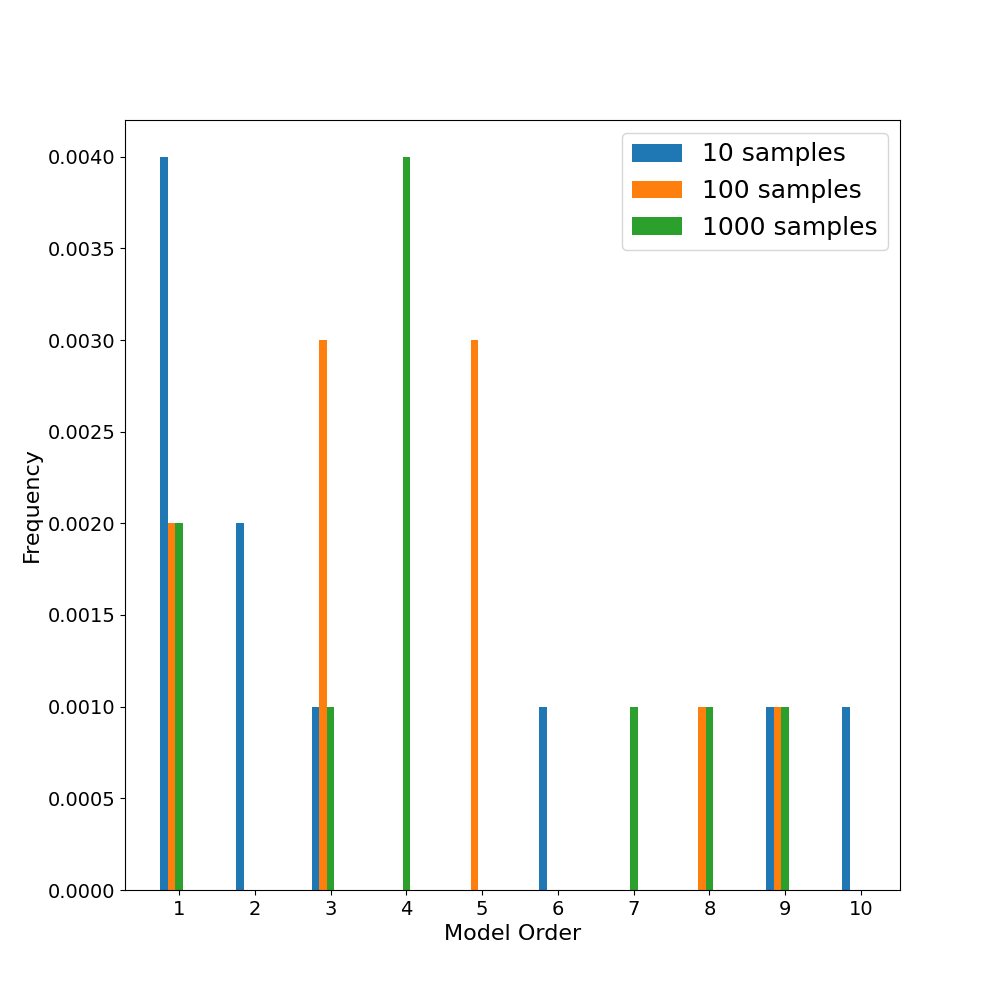

In [29]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


def plot_bar(freq):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    width = 0.1
    x = np.arange(len(model_orders))
    for i, n in enumerate(n_samples):
        ax.bar(x+i*width, freq[i], width, label=f"{n} samples")
    ax.set_xticks(x+2*width)
    ax.set_xticklabels(model_orders)
    ax.set_xlabel('Model Order')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()
freqs = kfold_validation(freq)
plot_bar(freqs)